In [1]:
import numpy as np
import pandas as pd
import volpriceinference as vl
# import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
vl.__version__

'0.0.09-py36_9'

In [5]:
kharpov = False

In [6]:
if kharpov:
    true_params = {'theta': 0.50, 
               'pi': -7,
               'phi': -.1,
               'scale': .1,
               'delta': 1.11,
               'rho': .4,
              }
else:
     true_params ={'delta': 0.15,
                   'rho': 0.74,
                   'scale': 9.63,
                   'phi': -0.31,
                   'pi': -0.13,
                   'theta': 0.58}
    
time_dim = 5000
sim_dim = 1000
innov_dim = 20

In [7]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [8]:
vl.compute_gamma(**true_params)

0.1593260890100913

In [9]:
total_true_params

{'delta': 0.15,
 'rho': 0.74,
 'scale': 9.63,
 'phi': -0.31,
 'pi': -0.13,
 'theta': 0.58,
 'gamma': 0.1593260890100913,
 'beta': 0.13048204164779256,
 'psi': -0.14804304090352505,
 'zeta': 0.9039}

In [10]:
true_params

{'delta': 0.15,
 'rho': 0.74,
 'scale': 9.63,
 'phi': -0.31,
 'pi': -0.13,
 'theta': 0.58}

In [11]:
total_true_params

{'delta': 0.15,
 'rho': 0.74,
 'scale': 9.63,
 'phi': -0.31,
 'pi': -0.13,
 'theta': 0.58,
 'gamma': 0.1593260890100913,
 'beta': 0.13048204164779256,
 'psi': -0.14804304090352505,
 'zeta': 0.9039}

## We start by examining the distributions of simulated data

In [12]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [13]:
omega, omega_cov = vl.estimate_params(data)

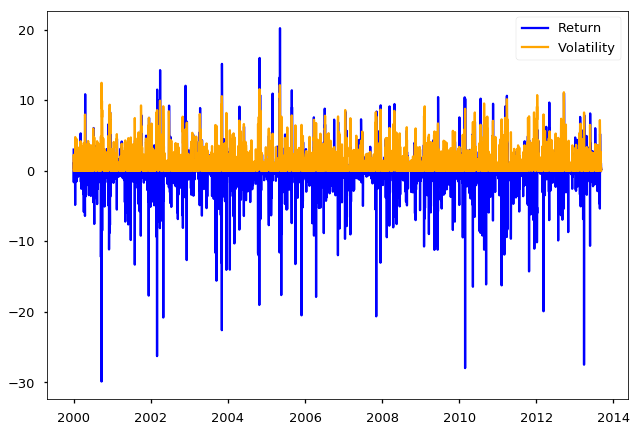

In [14]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [15]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,3.397969,-1.335325
rtn,-1.335325,6.726561


In [16]:
total_true_params

{'delta': 0.15,
 'rho': 0.74,
 'scale': 9.63,
 'phi': -0.31,
 'pi': -0.13,
 'theta': 0.58,
 'gamma': 0.1593260890100913,
 'beta': 0.13048204164779256,
 'psi': -0.14804304090352505,
 'zeta': 0.9039}

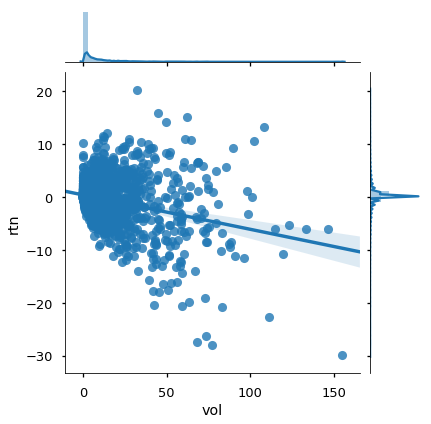

In [17]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [18]:
true_params['delta']

0.15

In [19]:
true_params['scale']

9.63

In [20]:
data.describe()

,vol,rtn
count,5000.000000,5000.000000
mean,5.099859,0.066892
std,12.771961,2.593562
min,0.000010,-29.879219
25%,0.002459,-0.099653
50%,0.213704,0.180246
75%,3.486733,0.622452
max,154.894969,20.185244


In [21]:
from libvolpriceinference import _simulate_autoregressive_gamma

In [22]:
def simulate_autoregressive_gamma(delta=1, rho=0, scale=1, initial_point=None, time_dim=100,
                                  start_date='2000-01-01'):
    """
    Provide draws from the ARG(1) process of Gourieroux & Jaisak.

    Parameters
    --------
    rho : scalar
        AR(1) coefficient
    delta : scalar
        intercept
    scale : scalar
    Returns

    -----
    draws : dataframe

    """
    # If initial_point is not specified, we start at the unconditional mean.

    initial_point = (scale * delta) / (1 - rho) if initial_point is None else initial_point

    draws = vl._simulate_autoregressive_gamma(delta=delta, rho=rho, scale=scale, initial_point=initial_point,
                                           time_dim=time_dim)
#     print(np.amin(draws))
    draws_df = pd.Series(draws, pd.date_range(start=start_date, freq='D', periods=len(draws)))
#     print(draws_df.min())
    return draws_df


In [23]:
umm =  simulate_autoregressive_gamma(delta=0.015, rho=0, scale=1, time_dim=1000)
                                  

In [24]:
umm.min()

1e-05

In [25]:
umm.head()

2000-01-01    0.00001
2000-01-02    0.00001
2000-01-03    0.00001
2000-01-04    0.00001
2000-01-05    0.00001
Freq: D, dtype: float64

## I now estimate all of the parameters

In [26]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [27]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [28]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(map(estimator, data_arr[:100]),
                                      total=len(data_arr)))

In [29]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean   / np.sqrt(np.diag(cov) / data.vol.size)

In [30]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, delta=true_params['delta'],
                                                   rho=true_params['rho'], scale=true_params['scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

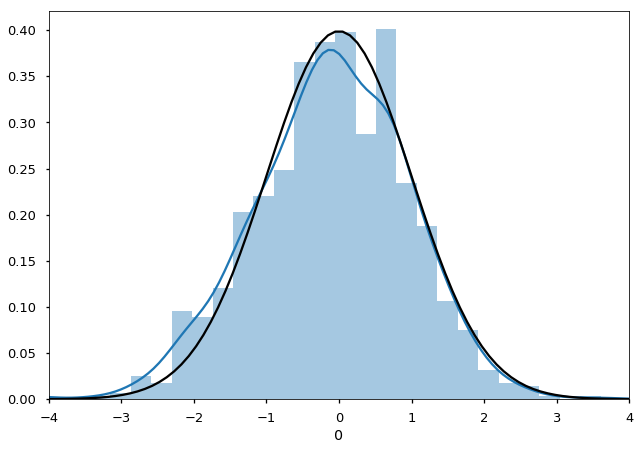

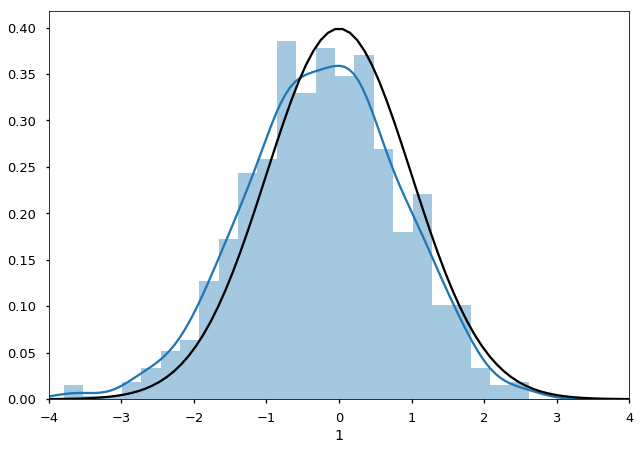

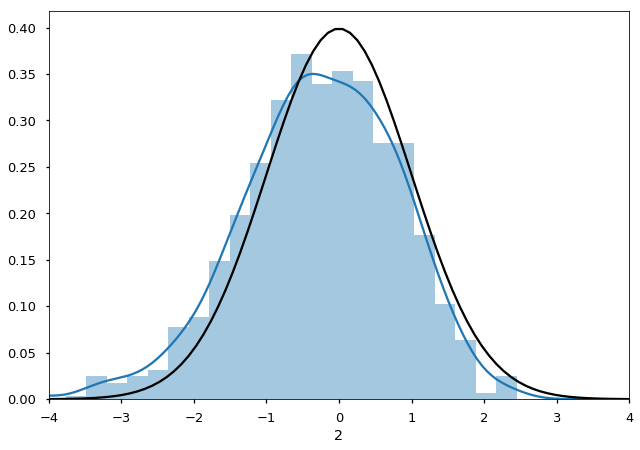

In [31]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

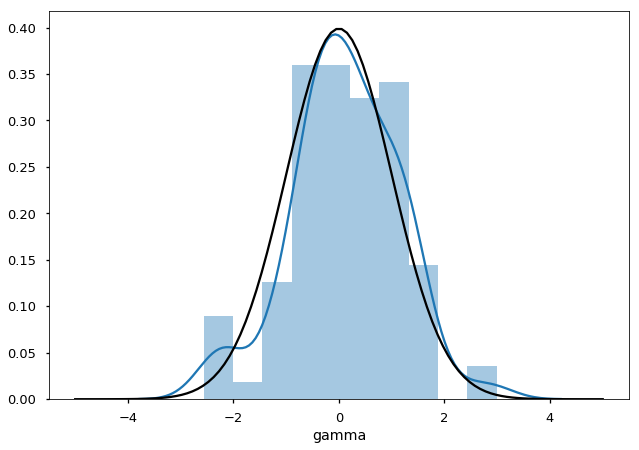

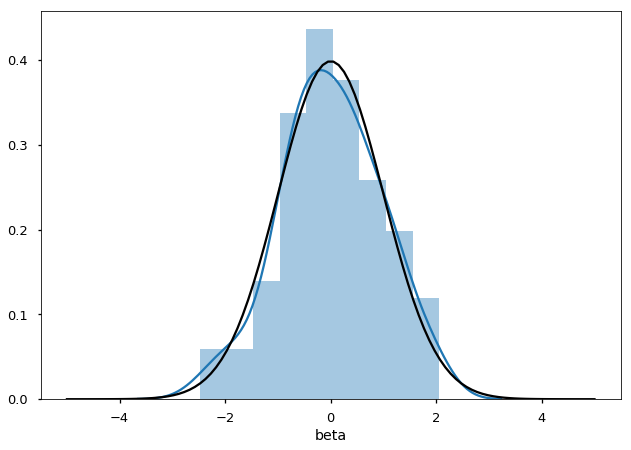

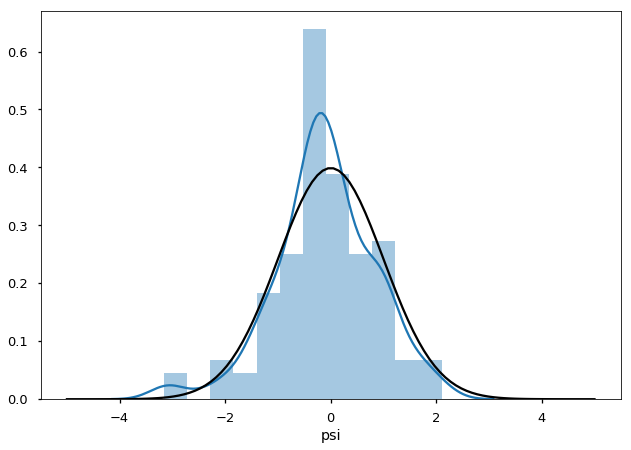

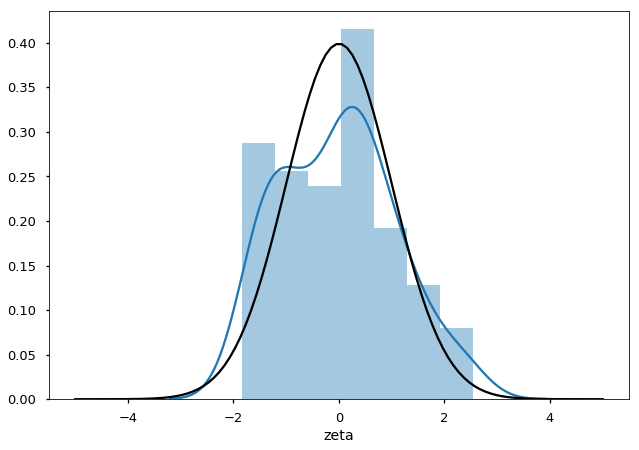

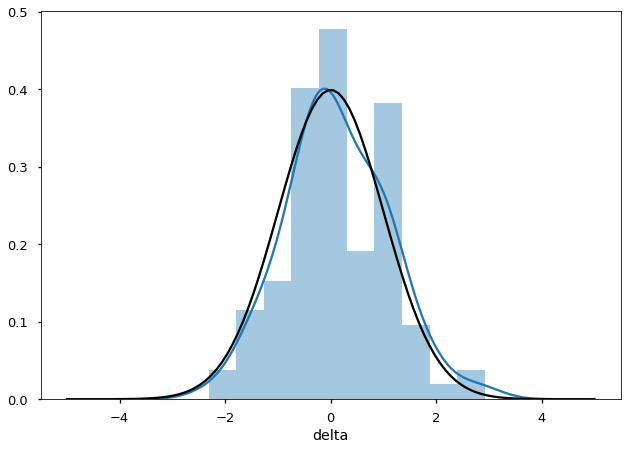

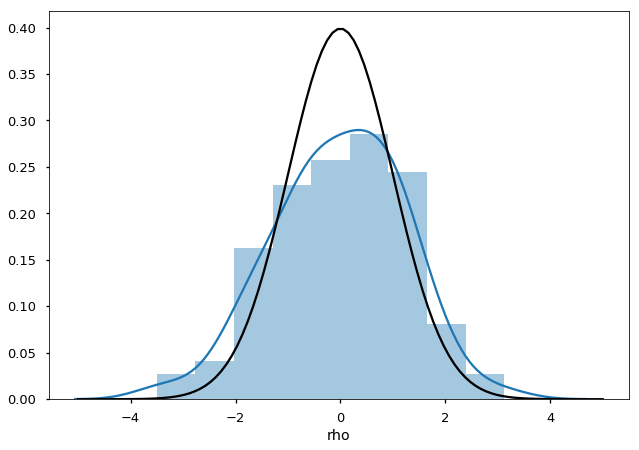

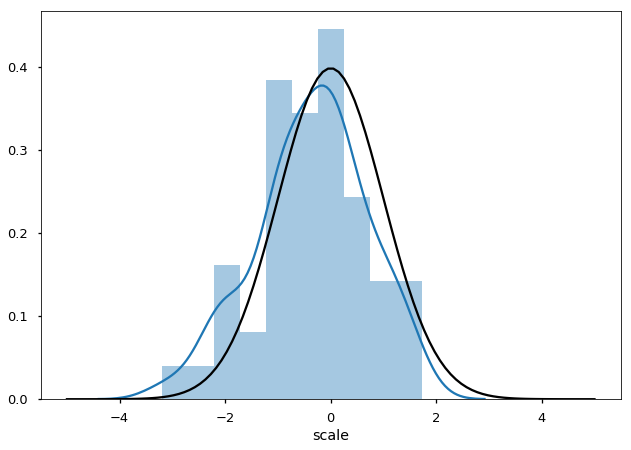

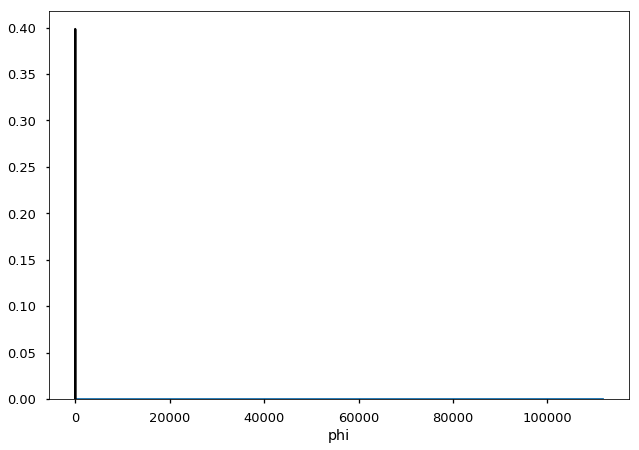

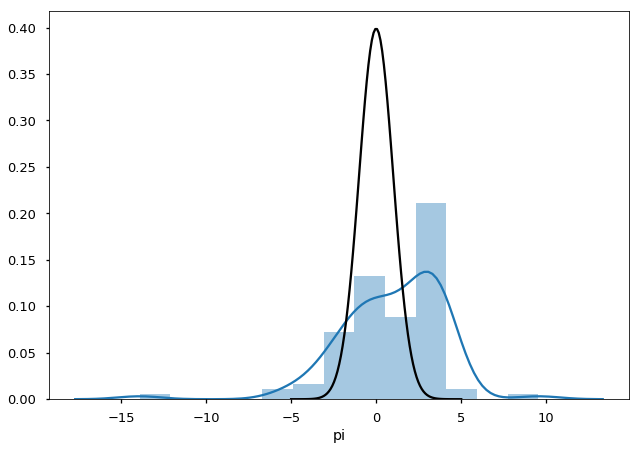

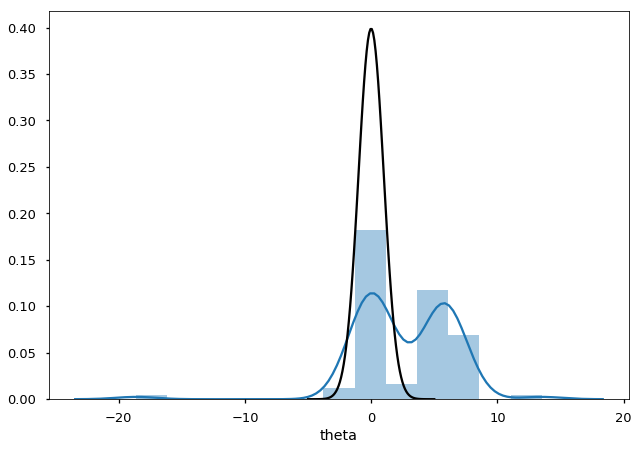

In [32]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)

# I now compute the robust conditional QLR statistic 

In [33]:
omega


{'gamma': 0.15944928216238952,
 'beta': 0.13049632491813443,
 'psi': -0.14875612648796346,
 'zeta': 0.8941367467715996,
 'delta': 0.15951039600273875,
 'rho': 0.6875946762816002,
 'scale': 9.990210727173157}

In [34]:
true_params

{'delta': 0.15,
 'rho': 0.74,
 'scale': 9.63,
 'phi': -0.31,
 'pi': -0.13,
 'theta': 0.58}

In [35]:
def compute_vals(idx):
    omega = pd.Series(est_arr[idx][0]).drop(['phi', 'pi', 'theta']).to_dict()
    omega_cov = est_arr[idx][1].drop(columns=['phi', 'pi', 'theta']).drop(index=['phi', 'pi', 'theta'])
    sims = vl.qlr_sim([true_params['phi'], -0.15, 0.3], omega=omega, omega_cov=omega_cov, innov_dim=100, case=1)
    val = vl.qlr_stat([true_params['phi'], -0.15, 0.3], omega=omega, omega_cov=omega_cov, case=1)[-1]
    
    return (val,) + tuple(sims)

In [36]:
results = pd.DataFrame(np.row_stack([compute_vals(idx) for idx in tqdm.tnrange(len(est_arr))]))

ValueError: array must not contain infs or NaNs

In [ ]:
results.head()

In [ ]:
import cdpm

In [ ]:
pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
                                    reference_data=results.iloc[:,1:])

In [ ]:
fig, ax = mpl.pyplot.subplots()
cdpm.pit_plot(pit, ax=ax)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=500, alpha=0.05, case=0,
                                        robust_quantile=True)

In [ ]:
returnval.mean()

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
else:
    filename = '../results/reject_prop_{}_{}.tmp.json'.format(innov_dim, true_params['phi'])
    
returnval.to_json(filename)

In [ ]:
returnval.head()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.robust_qlr_qauntile, kde_kws={"color": "red", "lw": 3, 'cumulative':True},
                 ax=ax4,hist=False, label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)